## Оценка датасета

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           roc_curve, auc, RocCurveDisplay)
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('twitchdata.csv')

**Оценим, какой атрибут может выступить в роли целевого класса (метки)**  

In [2]:
if 'Partnered' in df.columns:
    print("1. Partnered (бинарный):")
    print(df['Partnered'].value_counts())
    print(f"Тип данных: {df['Partnered'].dtype}")
    print()

if 'Mature' in df.columns:
    print("2. Mature (бинарный):")
    print(df['Mature'].value_counts())
    print(f"Тип данных: {df['Mature'].dtype}")
    print()

if 'Language' in df.columns:
    print("3. Language (мультиклассовый):")
    print(f"Уникальных языков: {df['Language'].nunique()}")
    print("Топ-5 языков:")
    print(df['Language'].value_counts().head())
    print()

1. Partnered (бинарный):
Partnered
True     978
False     22
Name: count, dtype: int64
Тип данных: bool

2. Mature (бинарный):
Mature
False    770
True     230
Name: count, dtype: int64
Тип данных: bool

3. Language (мультиклассовый):
Уникальных языков: 21
Топ-5 языков:
Language
English    485
Korean      77
Russian     74
Spanish     68
French      66
Name: count, dtype: int64



**Выберем Mature, поскольку:**  
- В нем умеренное кол-во классов (по сравнению с Language)
- Имеет бОльшую сбалансированность (по сравнению с Partnered)

In [3]:
def analyze_binary_balance(series, target_name):
    counts = series.value_counts()
    percentages = series.value_counts(normalize=True) * 100
    
    for value, count in counts.items():
        print(f"{value}: {count} записей ({percentages[value]:.1f}%)")
    
    imbalance_ratio = max(percentages) / min(percentages)
    print(f"\nКоэффициент дисбаланса: {imbalance_ratio:.2f}")
    
    if imbalance_ratio < 2:
        print("Хорошо сбалансированные классы")
    elif imbalance_ratio < 5:
        print("Умеренный дисбаланс")
    else:
        print("Сильный дисбаланс")
    
    return imbalance_ratio

if 'Mature' in df.columns:
    Mature_imbalance = analyze_binary_balance(df['Mature'], 'Mature Status')

False: 770 записей (77.0%)
True: 230 записей (23.0%)

Коэффициент дисбаланса: 3.35
Умеренный дисбаланс


**Предобработка**

In [11]:
df_clean = df[features + ['Mature']].dropna()

X = df_clean[features]
y = df_clean['Mature']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nРазмер train: {X_train.shape}")
print(f"Размер test: {X_test.shape}")


Размер train: (700, 6)
Размер test: (300, 6)


**Алгоритм kNN**

Оптимальное k: 14
Accuracy: 0.7600
Precision: 0.2000
Recall: 0.0145
F1-score: 0.0270


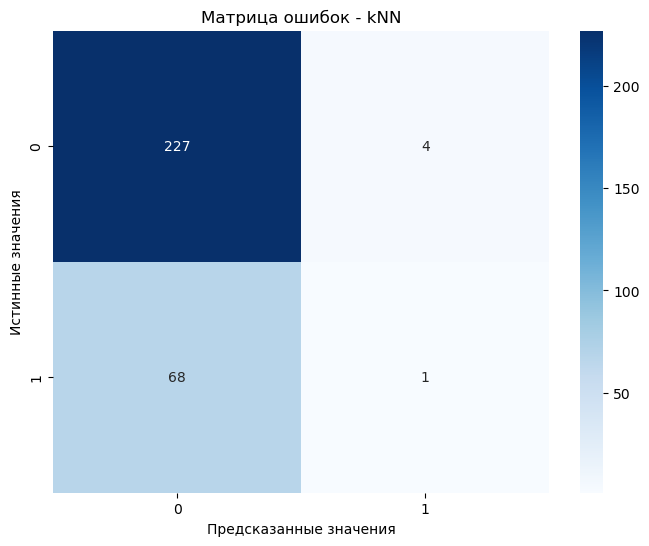

In [14]:
k_range = range(1, 21)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

optimal_k = k_range[np.argmax(k_scores)]
print(f"Оптимальное k: {optimal_k}")

knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_knn):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_knn):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_knn):.4f}")

cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок - kNN')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()

**Алгоритм дерева решений**

Лучшие параметры: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Лучшая accuracy: 0.7600
Accuracy: 0.7700
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


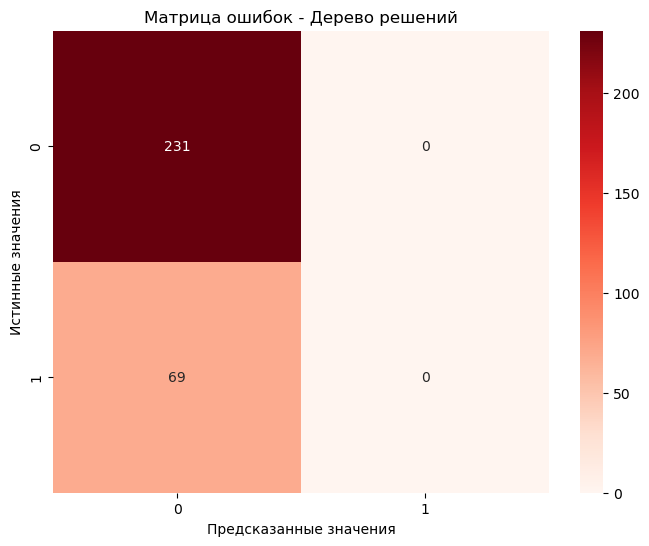

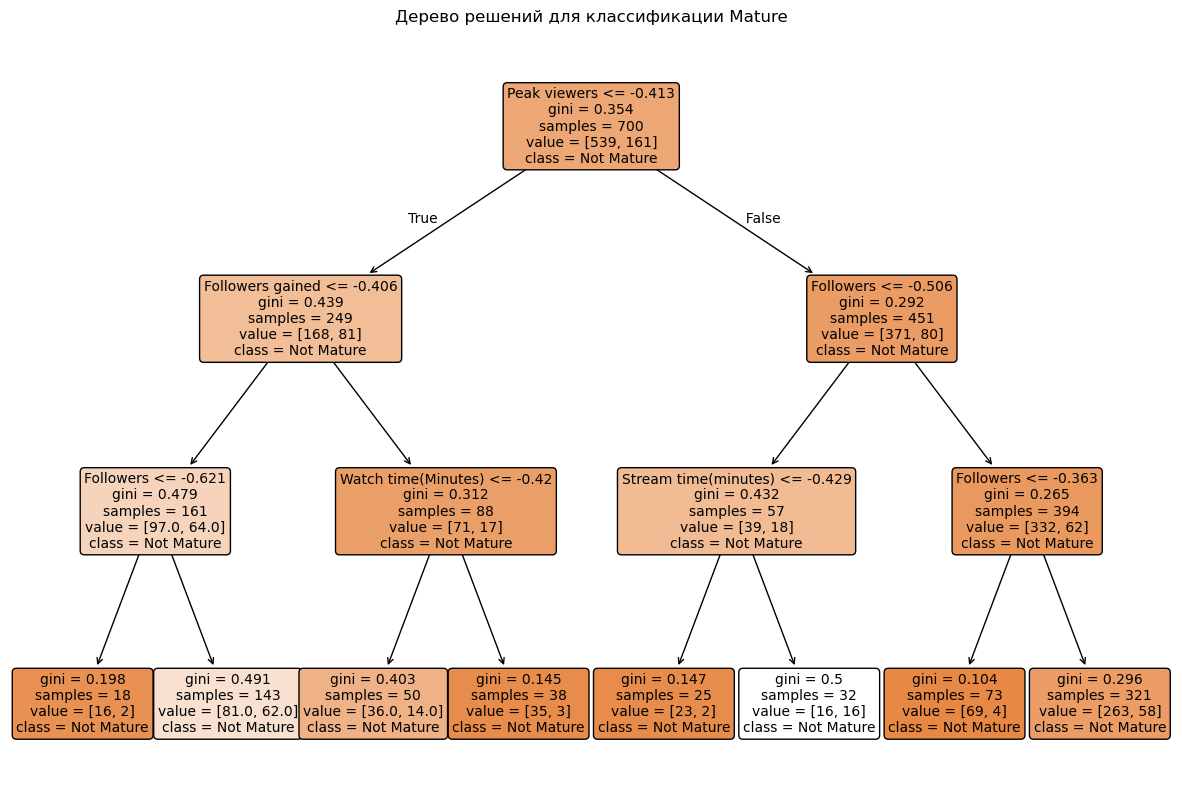

In [18]:
param_grid = {'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая accuracy: {grid_search.best_score_:.4f}")

dt_best = grid_search.best_estimator_
dt_best.fit(X_train, y_train)
y_pred_dt = dt_best.predict(X_test)
y_prob_dt = dt_best.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dt):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dt):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_dt):.4f}")

cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Reds')
plt.title('Матрица ошибок - Дерево решений')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()

plt.figure(figsize=(15, 10))
plot_tree(dt_best, feature_names=features, class_names=['Not Mature', 'Mature'], 
          filled=True, rounded=True, fontsize=10)
plt.title('Дерево решений для классификации Mature')
plt.show()

**Сравнение результатов классификации**

,Metric,kNN,Decision Tree
0,Accuracy,0.760000,0.77
1,Precision,0.200000,0.00
2,Recall,0.014493,0.00
3,F1-score,0.027027,0.00


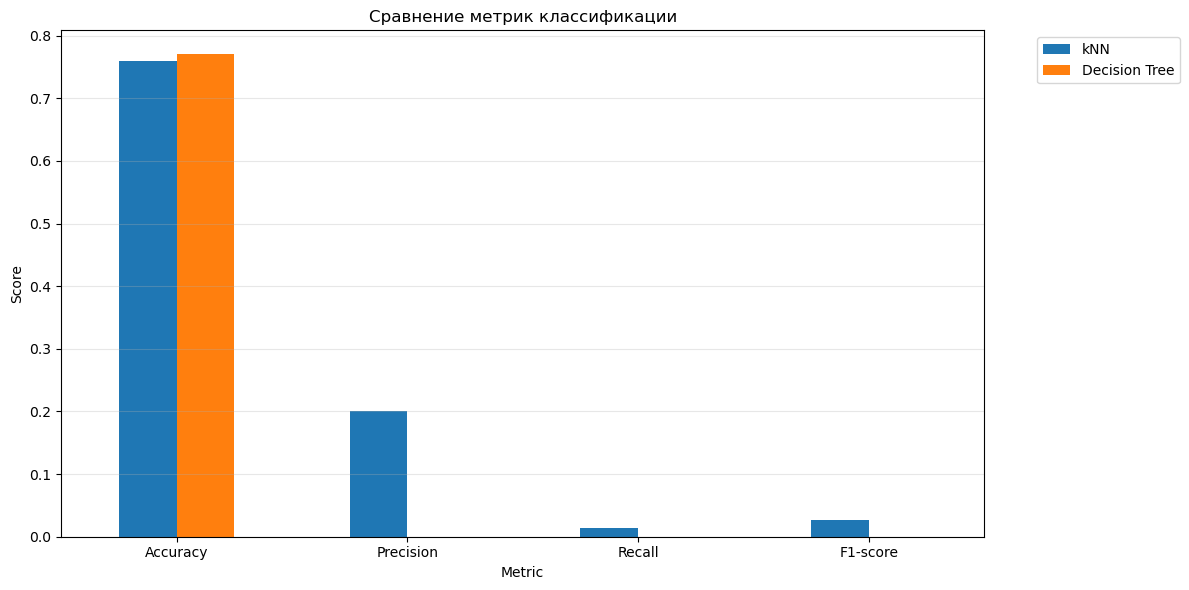

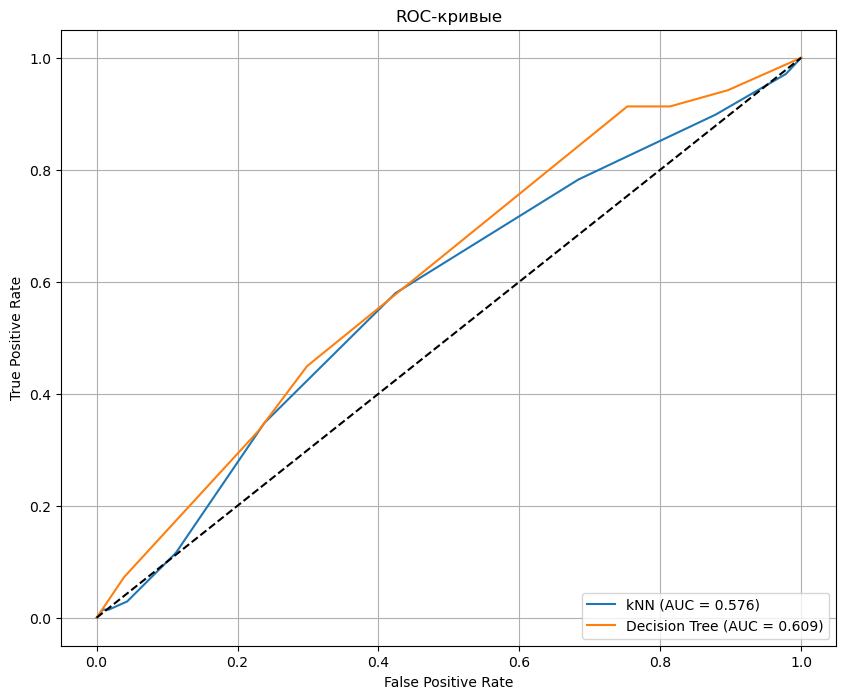

In [20]:
metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'kNN': [
        accuracy_score(y_test, y_pred_knn),
        precision_score(y_test, y_pred_knn),
        recall_score(y_test, y_pred_knn),
        f1_score(y_test, y_pred_knn)
    ],
    'Decision Tree': [
        accuracy_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_dt)
    ]
})

display(metrics_comparison)

# Визуализация сравнения метрик
metrics_comparison.set_index('Metric').plot(kind='bar', figsize=(12, 6))
plt.title('Сравнение метрик классификации')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ROC-кривые
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, label=f'kNN (AUC = {roc_auc_knn:.3f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Анализ полученных результатов**  
Алгоритм дерева решений справился хуже в предсказании из-за сильного дисбаланса классов: вероятно, алгоритм обучался на данных, в которых не было представлено класса Mature=True или данный класс был представлен в малых количествах. Также сказаться на результате могла низкая информативность признаков для целевой переменной.